In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import plotly.express as px
import warnings

from tqdm.notebook import tqdm

import pickle
import plotly.io as pio
pio.renderers.default = "svg"

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Import Quoilin dataset
Data available at: https://github.com/squoilin/Self-Consumption/releases Synthetic.Household.Profiles.h5

In [2]:
df = pd.read_pickle("../2_chapter/fr_quoilin_data_valence.pickle")
df.columns

Index(['2000900', '2000901', '2000903', '2000904', '2000905', '2000906',
       '2000907', '2000908', '2000909', '2000910',
       ...
       '2001188', '2001189', '2001190', '2001192', '2001193', '2001194',
       '2001195', '2001197', '2001199', 'pv_1kw'],
      dtype='object', length=174)

# Set study on 20 households

In [3]:
nb_houses = 20

In [4]:
house_ids=[
    "2000989",
    "2001197",
    "2000914",
    "2001123",
    "2000964",
    "2001189",
    "2001111",
    "2001179",
    "2000909",
    "2000918",
    "2000994",
    "2001107",
    "2000913",
    "2001139",
    "2000960",
    "2001149",
    "2001165",
    "2000954",
    "2001114",
    "2000926",
]
df = df[house_ids + ["pv_1kw"]]
print(f"Average consumption is {round((df[house_ids].sum() * 15 / 60).mean() / 1000, 2)} MWh")

Average consumption is 5.56 MWh


In [5]:
_individuals = df.copy()
df["community_kW"] = df[house_ids].sum(axis=1)
df.drop(house_ids, axis=1, inplace=True)

In [6]:
individuals = _individuals.copy()

# Fix variables
deltat = timedelta(minutes=15)

# Training = 31 days + 1 day for lagged values
training = timedelta(days=31)

# Where do we forecast?
start = datetime(2019, 5, 30, 6, 0, 0)
full_horizon = timedelta(days=7)

# When do we calibrate
start_calibrate = start - timedelta(days=2)
end_calibrate = start - deltat
start_training_to_calibrate = start_calibrate - training
end_training_to_calibrate = start_calibrate - deltat

# To truncate data
end = start + full_horizon + timedelta(days=7)  # keep a few days after anyway

pv_size = 3
individuals = individuals.loc[start_training_to_calibrate-timedelta(days=1):end, :].copy()
for col in individuals.columns:
    individuals[col] -= pv_size * individuals["pv_1kw"]
individuals.drop(columns=["pv_1kw"], inplace=True)

sub_house_ids = [house_ids[i] for i in [0, 4, 19, 13, 14]]

# ------ Section by-passed with (batch_forecast.py)

In [7]:
def get_gof(df, result, ref_col, pred_col):
    """
    gof = (1 - NRMSE) * 100
    """
    pred = result.loc[:, [pred_col]].copy()
    #if pred.index.tzinfo is None:
    #    pred.index = pred.index.tz_localize("UTC")
    pred.columns = ["prediction"]

    ref = df.loc[pred.index[0]:pred.index[-1], [ref_col]].copy()
    ref.columns = ["target"]

    nrmse = (np.linalg.norm(ref["target"].values - pred["prediction"].values, 2) 
           / np.linalg.norm(ref["target"].values - ref["target"].mean(), 2))
    return 100.0 * (1.0 - np.clip(nrmse, a_min=0.0, a_max=1.0))

start_training = start - training
end_training = start - deltat

horizon = timedelta(days=2) - deltat
end_complete_pred = start + timedelta(days=7)

freqs = ["2D"]
freq_deltas = [timedelta(days=2) - deltat]

# Forecast at freq = 2 days

In [8]:
house_forecast = {}

for freq in freqs:
    with open(f'tmp_forecasts/house_forecast_{freq}.pickle', 'rb') as handle:
        unserialized_data = pickle.load(handle)
    house_forecast[freq] = unserialized_data
    
# Reformat as a dict of freq with a list of pd.DataFrame with all houses.
house_forecast_list = {}

for freq in freqs:
    house_forecast_list[freq] = []
    
    for i in range(0, len(house_forecast[freq][sub_house_ids[0]])):
        tmp = pd.concat([house_forecast[freq][house_id][i] for house_id in sub_house_ids], axis=1)
        house_forecast_list[freq].append(tmp)

# Optimize at freq =2 days

In [9]:
from pyomo.opt import SolverFactory
from pyomo.environ import *
from dataclasses import dataclass
from datetime import timedelta


@dataclass
class OptimizeBatteries_quadratic:
    grid_buy: float
    grid_fee: float
    battery_aging_cost: float = 0.0
    only_return_schedules: bool = True
    freq: int = 15
    optim_horizon: timedelta = timedelta(days=2)
    solver: str = "gurobi"
    solver_path: str = None
    verbose: bool = False
    
    def _solve(self, netloads, members, assets):
        m = ConcreteModel()
        batteries = assets["batt"]

        m.horizon = Set(initialize=list(netloads.keys()), ordered=True)
        m.members = Set(initialize=list(members.keys()), ordered=True)
        m.batteries = Set(initialize=list(batteries.keys()), ordered=True)

        m.community_import = Var(m.horizon, domain=NonNegativeReals)
        m.member_import = Var(m.horizon, m.members, domain=NonNegativeReals)
        m.batteryin = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryout = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryenergy = Var(m.horizon, m.batteries, domain=NonNegativeReals)

        m.grid_buy = Param(initialize=self.grid_buy)
        m.grid_fee = Param(initialize=self.grid_fee)
        m.battery_aging_cost = Param(initialize=self.battery_aging_cost)
        m.deltat = Param(initialize=self.freq / 60)
        m.last = Param(initialize=m.horizon.last())

        # Battery constraints
        def r_battery_max_powerin(m, t, b):
            return m.batteryin[t, b] <= batteries[b]["max_kw"]

        def r_battery_max_powerout(m, t, b):
            return m.batteryout[t, b] <= batteries[b]["min_kw"]

        def r_battery_energy(m, t, b):
            if t == 0:
                return m.batteryenergy[t, b] == batteries[b]["init_kwh"]
            else:
                return (
                    m.batteryenergy[t, b]
                    == m.batteryenergy[t - 1, b]
                    + m.batteryin[t - 1, b] * m.deltat * batteries[b]["eta"]
                    - m.batteryout[t - 1, b] * m.deltat / batteries[b]["eta"]
                )

        def r_battery_min_energy(m, t, b):
            return (
                m.batteryenergy[t, b]
                >= batteries[b]["max_kwh"] * batteries[b]["offset"]
            )

        def r_battery_max_energy(m, t, b):
            return m.batteryenergy[t, b] <= batteries[b]["max_kwh"] * (
                1 - batteries[b]["offset"]
            )

        def r_battery_end_power_out(m, b):
            return m.batteryout[m.last, b] == 0.0

        def r_battery_end_power_in(m, b):
            return m.batteryin[m.last, b] == 0.0

        # Energy balance
        def r_community_import(m, t):
            return m.community_import[t] >= sum(
                m.batteryin[t, b] - m.batteryout[t, b] for b in m.batteries
            ) + sum(netloads[t][p] for p in m.members)

        def r_member_import(m, t, p):
            return (
                m.member_import[t, p]
                >= sum(
                    m.batteryin[t, b] - m.batteryout[t, b] for b in members[p]["batt"]
                )
                + netloads[t][p]
            )
        
        m.r1 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerin)
        m.r2 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerout)
        m.r3 = Constraint(m.horizon, m.batteries, rule=r_battery_energy)
        m.r4 = Constraint(m.horizon, m.batteries, rule=r_battery_min_energy)
        m.r5 = Constraint(m.horizon, m.batteries, rule=r_battery_max_energy)
        m.r7 = Constraint(m.batteries, rule=r_battery_end_power_out)
        m.r8 = Constraint(m.batteries, rule=r_battery_end_power_in)
        m.r9 = Constraint(m.horizon, rule=r_community_import)
        m.r10 = Constraint(m.horizon, m.members, rule=r_member_import)

        def objective_function_bis(m):
            return sum(
                m.grid_buy * m.community_import[i]
                + m.grid_fee
                * (
                    sum(m.member_import[i, p] for p in m.members)
                    - m.community_import[i]
                )
                + m.battery_aging_cost * sum((1/netloads[i][p] * (m.batteryin[i, b] + m.batteryout[i, b]))**2 for b, p in zip(m.batteries, m.members))
                for i in m.horizon
            )
     
        def objective_function(m):
            return sum(
                m.grid_buy * m.community_import[i]
                + m.grid_fee
                * (
                    sum(m.member_import[i, p] for p in m.members)
                    - m.community_import[i]
                )
                + m.battery_aging_cost * sum((m.batteryin[i, b] + m.batteryout[i, b])**2 for b in m.batteries)
                for i in m.horizon
            )
        m.objective = Objective(rule=objective_function_bis, sense=minimize)

        with SolverFactory(self.solver, executable=self.solver_path) as opt:
            results = opt.solve(m, tee=False)
            if self.verbose:
                print(results)
        return m
   
    def solve(self, df, member_ids, spec):
        netloads = df.copy()
        netloads.index = range(0, len(netloads))
        netloads = netloads.T.to_dict()
        
        members = {member_id:{"batt": [int(i)]} for i, member_id in enumerate(member_ids)}
        
        assets = {}
        assets["batt"] = {i:{
            "min_kw": spec[i]["min_kw"],
            "max_kw": spec[i]["max_kw"],
            "max_kwh": spec[i]["max_kwh"],
            "eta": spec[i]["eta"],
            "offset": spec[i]["offset"],
            "init_kwh": spec[i]["init_kwh"],
            #"end_kwh": spec["max_kwh"] * spec["offset"]
        } for i, member_id in enumerate(member_ids)}

        model = self._solve(netloads, members, assets)
        return self.postprocess(model, df, member_ids)

    def postprocess(self, model, predictions, member_ids):
        schedules = get_timevar_from_pyomo(model, predictions.index)
        schedules["schedules"] = (
            schedules["batteryin"] - schedules["batteryout"]
        ).copy()

        if self.only_return_schedules:
            schedules = schedules["schedules"]
            schedules.columns = member_ids
        return schedules

def get_timevar_from_pyomo(model, timeindex):
    results = {}
    for var in model.component_objects(Var):
        if var.index_set()._implicit_subsets is None:
            results[var.name] = pd.DataFrame(
                index=[var.name], data=getattr(model, var.name).get_values()
            ).transpose()
            results[var.name].index = timeindex
        else:
            results[var.name] = (
                pd.DataFrame(index=["none"], data=getattr(model, var.name).get_values())
                .transpose()
                .unstack(level=1)
            )
            results[var.name].columns = results[var.name].columns.levels[1]
            results[var.name].index = timeindex
    return results

# Check value to assign to battery aging without changing optimal cost

In [ ]:
objective_values = []

battery_size = 5
ref_spec = {
        "min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "init_kwh": battery_size * 0.01,
        "eta": 0.95,
        "offset": 0.01}
spec = [dict(ref_spec) for i in sub_house_ids]

_start = end_training + deltat
_end = _start + timedelta(days=7)
tmp_netload = individuals.loc[_start:_end, sub_house_ids].copy()

aging_costs = np.linspace(0, 1e-3, 15)

for aging_cost in tqdm(aging_costs, desc="Searching"):
    model = OptimizeBatteries_quadratic(
        grid_buy=0.1740, grid_fee=0.0371, battery_aging_cost=aging_cost,
        verbose=False, only_return_schedules=False)
    
    schedule = model.solve(tmp_netload, sub_house_ids, spec)
    
    # Rebuild objective func without ageing
    objective = sum(
        model.grid_buy * schedule["community_import"]["community_import"].iloc[i]
        + model.grid_fee
        * (
            sum(schedule["member_import"][p].iloc[i] for p in schedule["member_import"].columns)
            - schedule["community_import"]["community_import"].iloc[i]
        )
        #+ model.battery_aging_cost * sum(
        #    (schedule["batteryin"][b].iloc[i]
        #     + schedule["batteryout"][b].iloc[i])**2 for b in schedule["batteryin"].columns)
        for i in range(0, len(schedule["community_import"]))
    )    
    objective_values.append(np.round(objective, 6))

In [ ]:
graph = pd.DataFrame(index=aging_costs, data={"objective_func": objective_values})

_fig = px.line(graph)
_fig.data[-1].update(line_width=5)
_fig.update_layout(
    layout,
    height=500,
    width=800,
    yaxis_title="Objective func cost without aging",
    xaxis_title="Aging cost",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=True, xaxis_linewidth=2, xaxis_linecolor='black',
    showlegend=False)
_fig.show()

We take 100 less than when it starts to change

# Apply to the 2 days scenario

In [10]:
freqs

['2D']

In [11]:
[(a + deltat).total_seconds() / 3600 for a in freq_deltas]

[48.0]

In [12]:
netload_freq = {}
for freq, freq_delta in zip(freqs, freq_deltas):

    # Concat forecasts
    size = len(house_forecast_list[freq])
    tmp = []
    for i in range(0, size):
        tmp_start = house_forecast_list[freq][i].index[0]
        tmp.append(house_forecast_list[freq][i].loc[tmp_start:tmp_start + freq_delta, :].copy())
    
    netload_freq[freq] = pd.concat(tmp, axis=0)

In [13]:
schedules_concat = {}
energy_concat = {}
battery_sizes = np.linspace(0, 10, 21)

freq = freqs[0]
freq_delta = freq_deltas[0]
aging_cost = 1e-6

for battery_size in tqdm(battery_sizes, desc="Battery size"):
    schedules_concat[battery_size] = []
    energy_concat[battery_size] = []      
    
    ref_spec = {
            "min_kw": battery_size / 2,
            "max_kw": battery_size / 2,
            "max_kwh": battery_size,
            "init_kwh": battery_size * 0.01,
            "eta": 0.95,
            "offset": 0.01}
    spec = [dict(ref_spec) for i in sub_house_ids]
    
    
    model = OptimizeBatteries_quadratic(
        grid_buy=0.1740, grid_fee=0.0371, battery_aging_cost=aging_cost,
        verbose=False, only_return_schedules=False)
    
    date_range = pd.date_range(end_training + deltat, end_complete_pred, freq=freq)
    nb_iteration = len(date_range)
    for jndex, opti_start in enumerate(date_range):
        
        end_optimization = opti_start + horizon + deltat
        if end_optimization > end_complete_pred:
            end_optimization = end_complete_pred
        
        tmp_netload = netload_freq[freq].loc[opti_start:end_optimization, sub_house_ids]
        schedule = model.solve(tmp_netload, sub_house_ids, spec)
        
        # If not last iteration
        if not jndex == nb_iteration - 1:
            battery_time = opti_start + freq_delta + deltat
            for i, house_id in enumerate(sub_house_ids):
                spec[i]["init_kwh"] = float(schedule["batteryenergy"].at[battery_time, i])

        schedules_concat[battery_size].append(schedule["schedules"].loc[opti_start:opti_start+freq_delta].copy())
        energy_concat[battery_size].append(schedule["batteryenergy"].loc[opti_start:opti_start+freq_delta].copy())
    schedules_concat[battery_size] = pd.concat(schedules_concat[battery_size], axis=0)
    energy_concat[battery_size] = pd.concat(energy_concat[battery_size], axis=0)

Battery size:   0%|          | 0/21 [00:00<?, ?it/s]

### Perfect optimization

In [14]:
perfect_schedules_concat = {}
perfect_energy_concat = {}

for battery_size in tqdm(battery_sizes, desc="Battery size"):
    perfect_schedules_concat[battery_size] = []
    perfect_energy_concat[battery_size] = []      
    
    ref_spec = {
            "min_kw": battery_size / 2,
            "max_kw": battery_size / 2,
            "max_kwh": battery_size,
            "init_kwh": battery_size * 0.01,
            "eta": 0.95,
            "offset": 0.01}
    spec = [dict(ref_spec) for i in sub_house_ids]
    
    
    model = OptimizeBatteries_quadratic(
        grid_buy=0.1740, grid_fee=0.0371, battery_aging_cost=0,
        verbose=False, only_return_schedules=False)
    
    date_range = pd.date_range(end_training + deltat, end_complete_pred, freq=freq)
    nb_iteration = len(date_range)
    for jndex, opti_start in enumerate(date_range):
        
        end_optimization = opti_start + horizon + deltat
        if end_optimization > end_complete_pred:
            end_optimization = end_complete_pred
        
        tmp_netload = individuals.loc[opti_start:end_optimization, sub_house_ids]
        schedule = model.solve(tmp_netload, sub_house_ids, spec)
        
        # If not last iteration
        if not jndex == nb_iteration - 1:
            battery_time = opti_start + freq_delta + deltat
            for i, house_id in enumerate(sub_house_ids):
                spec[i]["init_kwh"] = float(schedule["batteryenergy"].at[battery_time, i])

        perfect_schedules_concat[battery_size].append(schedule["schedules"].loc[opti_start:opti_start+freq_delta].copy())
        perfect_energy_concat[battery_size].append(schedule["batteryenergy"].loc[opti_start:opti_start+freq_delta].copy())
    perfect_schedules_concat[battery_size] = pd.concat(perfect_schedules_concat[battery_size], axis=0)
    perfect_energy_concat[battery_size] = pd.concat(perfect_energy_concat[battery_size], axis=0)

Battery size:   0%|          | 0/21 [00:00<?, ?it/s]

## Compare in €

In [15]:
def community_bill(df, member_ids, timing, deltat=15, buy_price=0.1740, exchange_price=0.0371):
    """Return cost for the community
    cost = buy [€/kWh] imports + pay fees on exchanges [€]
    """
    # Community import (sum then max)
    pos_netload = (
        (
            df[[a for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
            #- df[[prod_col for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
        )
        .clip(lower=0)
        .sum()
        * deltat
        / 60
    )

    # Sum of ind import (max then sum)
    pos_n_netload = (
        sum(
            (df[a]).groupby(pd.Grouper(freq=timing)).sum().clip(lower=0).sum()
            #(df[a] - df[prod_col]).groupby(pd.Grouper(freq=timing)).sum().clip(lower=0).sum()
            for a in member_ids
        )
        * deltat
        / 60
    )

    return np.round(
        buy_price * pos_netload + exchange_price * (pos_n_netload - pos_netload), 3
    )

In [16]:
_start = end_training + deltat
_end = end_complete_pred

In [17]:
cost_2d = []

for battery_size in battery_sizes:
    graph = schedules_concat[battery_size].copy()
    graph.columns = sub_house_ids
    for col in graph.columns:
        graph[col] += individuals.loc[_start:_end, col]

    forecast_cost = community_bill(graph, sub_house_ids, timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
    print(f"Forecast at {battery_size}kWh, cost = {np.round(forecast_cost, 2)} €")
    cost_2d.append(forecast_cost)

Forecast at 0.0kWh, cost = 35.33 €
Forecast at 0.5kWh, cost = 32.93 €
Forecast at 1.0kWh, cost = 30.56 €
Forecast at 1.5kWh, cost = 28.22 €
Forecast at 2.0kWh, cost = 25.92 €
Forecast at 2.5kWh, cost = 23.71 €
Forecast at 3.0kWh, cost = 21.68 €
Forecast at 3.5kWh, cost = 19.76 €
Forecast at 4.0kWh, cost = 18.03 €
Forecast at 4.5kWh, cost = 16.43 €
Forecast at 5.0kWh, cost = 14.94 €
Forecast at 5.5kWh, cost = 13.58 €
Forecast at 6.0kWh, cost = 12.42 €
Forecast at 6.5kWh, cost = 11.51 €
Forecast at 7.0kWh, cost = 10.71 €
Forecast at 7.5kWh, cost = 10.17 €
Forecast at 8.0kWh, cost = 9.94 €
Forecast at 8.5kWh, cost = 9.74 €
Forecast at 9.0kWh, cost = 9.52 €
Forecast at 9.5kWh, cost = 9.33 €
Forecast at 10.0kWh, cost = 9.13 €


In [18]:
cost_perfect = []

for battery_size in battery_sizes:
    graph = perfect_schedules_concat[battery_size].copy()
    graph.columns = sub_house_ids
    for col in graph.columns:
        graph[col] += individuals.loc[_start:_end, col]

    forecast_cost = community_bill(graph, sub_house_ids, timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
    print(f"Forecast at {battery_size}kWh, cost = {np.round(forecast_cost, 2)} €")
    cost_perfect.append(forecast_cost)

Forecast at 0.0kWh, cost = 35.33 €
Forecast at 0.5kWh, cost = 32.74 €
Forecast at 1.0kWh, cost = 30.3 €
Forecast at 1.5kWh, cost = 27.88 €
Forecast at 2.0kWh, cost = 25.47 €
Forecast at 2.5kWh, cost = 23.08 €
Forecast at 3.0kWh, cost = 20.72 €
Forecast at 3.5kWh, cost = 18.37 €
Forecast at 4.0kWh, cost = 16.04 €
Forecast at 4.5kWh, cost = 13.71 €
Forecast at 5.0kWh, cost = 11.61 €
Forecast at 5.5kWh, cost = 9.88 €
Forecast at 6.0kWh, cost = 8.68 €
Forecast at 6.5kWh, cost = 8.07 €
Forecast at 7.0kWh, cost = 7.56 €
Forecast at 7.5kWh, cost = 7.08 €
Forecast at 8.0kWh, cost = 6.61 €
Forecast at 8.5kWh, cost = 6.19 €
Forecast at 9.0kWh, cost = 5.78 €
Forecast at 9.5kWh, cost = 5.39 €
Forecast at 10.0kWh, cost = 5.0 €


In [19]:
graph = individuals.loc[_start:_end, sub_house_ids].copy()

forecast_cost = community_bill(graph, sub_house_ids, timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"PV only cost = {np.round(forecast_cost, 2)} €")

forecast_cost = community_bill(graph, sub_house_ids, timing="1D", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"Theoretical 1d cost = {np.round(forecast_cost, 2)} €")

forecast_cost = community_bill(graph, sub_house_ids, timing="2D", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"Theoretical 2d cost = {np.round(forecast_cost, 2)} €")

forecast_cost = community_bill(graph, sub_house_ids, timing="365D", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"Theoretical cost = {np.round(forecast_cost, 2)} €")

PV only cost = 35.33 €
Theoretical 1d cost = 7.89 €
Theoretical 2d cost = 2.33 €
Theoretical cost = 0.0 €


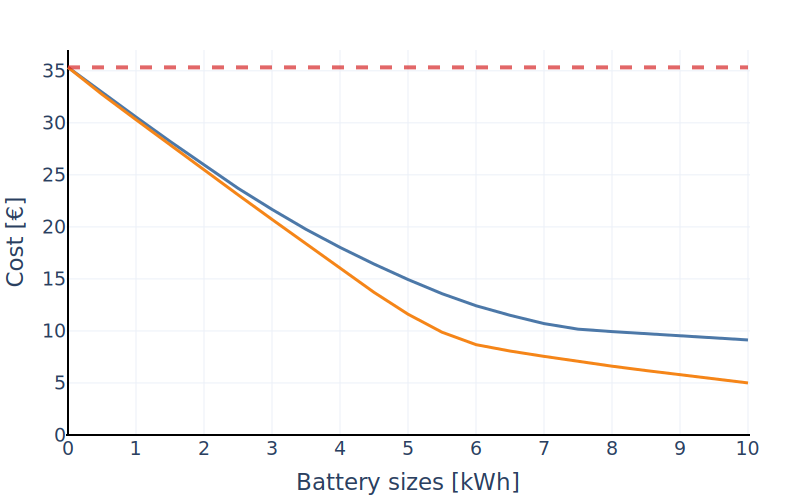

In [20]:
graph = pd.DataFrame(index=battery_sizes, data={"2D": cost_2d,
                                                "Perfect": cost_perfect})

fig = px.line(graph)

fig.update_traces(line_width=3)

# Red dashed line
fig.add_shape(
 type='line',
 x0=battery_sizes[0],
 x1=battery_sizes[-1],
 y0=35.33,
 y1=35.33,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(214, 39, 40, 0.7)'})

fig.update_layout(
    layout,
    height=500,
    width=800,
    yaxis_title="Cost [€]",
    xaxis_title="Battery sizes [kWh]",
    xaxis_dtick=1,
    yaxis_range=[0, 37],
    yaxis_showline=False, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    showlegend=False)
fig.show()
#fig.write_image(f"results/cost_battery_size.svg")

In [21]:
(graph["2D"] - graph["Perfect"]) * 100 / (35.33 - graph["Perfect"])

0.0     -0.000000
0.5      7.363146
1.0      5.070591
1.5      4.602791
2.0      4.633479
2.5      5.136371
3.0      6.583630
3.5      8.208999
4.0     10.329636
4.5     12.580362
5.0     14.046625
5.5     14.548955
6.0     14.034824
6.5     12.607755
7.0     11.341951
7.5     10.954589
8.0     11.578508
8.5     12.169675
9.0     12.628194
9.5     13.175473
10.0    13.624374
dtype: float64